In [3]:

import numpy as np
import astropy.units as u
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload
from astropy.io import fits
import copy
import time
from datetime import timezone 

import ray

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize, CenteredNorm
from matplotlib.patches import Circle, Rectangle
from matplotlib.gridspec import GridSpec

import esc_llowfsc_sim
from esc_llowfsc_sim.math_module import xp, xcipy, ensure_np_array
from esc_llowfsc_sim import utils, dm, iefc
import esc_llowfsc_sim.esc_fraunhofer as esc
from esc_llowfsc_sim import shmim_utils

from magpyx.utils import ImageStream

model_params = utils.load_pickle(esc_llowfsc_sim.path/'data/example_fraunhofer_params_1K.pkl')
M = esc.single(**model_params)

In [4]:
CAMSCI_STREAM = ImageStream('camscisim')
CAMSCI_STREAM = ImageStream('camscisim')
CAMSCI_SHUTTER_STREAM = ImageStream('camscishutter')
CAMSCI_EXPTIME_STREAM = ImageStream('camsciexptime')
DM_STREAM3 = ImageStream('dm00disp03')
FSM_STREAM1 = ImageStream('fsm01')
FSM_STREAM2 = ImageStream('fsm02')

iwa = 3
owa = 10

dh_mask = ensure_np_array( utils.create_annular_focal_plane_mask(
    M.ncamsci,
    M.camsci_pxscl_lamDc,
    iwa, 
    owa,  
    edge=iwa,
    centering='odd', # odd or even
    rotation=90,
    x_shift=0,
    y_shift=0,
) )


In [72]:
calib_data = utils.load_pickle('flight-sim-data-1K/ground_calibration_2.pkl')
zernike_modes = ensure_np_array(calib_data['zer_modes'])
zer_modal_matrix = ensure_np_array(calib_data['zer_modal_matrix'])
dm_mask = ensure_np_array(calib_data['dm_mask'])
z_pinv = np.linalg.pinv(zer_modal_matrix)

shmim_utils.write( z_pinv.dot(DM_STREAM3.grab_latest()[dm_mask]), DM_STREAM3_OFFSET )

In [73]:
import threading
class Process(threading.Timer):  
    def run(self):
        while not self.finished.wait(self.interval):  
            self.function(*self.args, **self.kwargs)

def update_ff_offset(
        DM_STREAM,
        DM_STREAM_OFFSET,
        dm_mask,
        z_pinv,
    ):

    DM_STREAM_OFFSET.write(z_pinv.dot(DM_STREAM.grab_latest()[dm_mask])[:,None].T)

In [11]:
ff_freq = 400
ff_interval = 1/ff_freq

args = [
    DM_STREAM3,
    DM_STREAM3_OFFSET,
    dm_mask,
    z_pinv,
]

ff_process = shmim_utils.Process(
    ff_interval, 
    update_ff_offset, 
    args, # the args
    # kwargs, # the kwargs
)

In [12]:
ff_process.start()

In [21]:
ff_process.cancel()

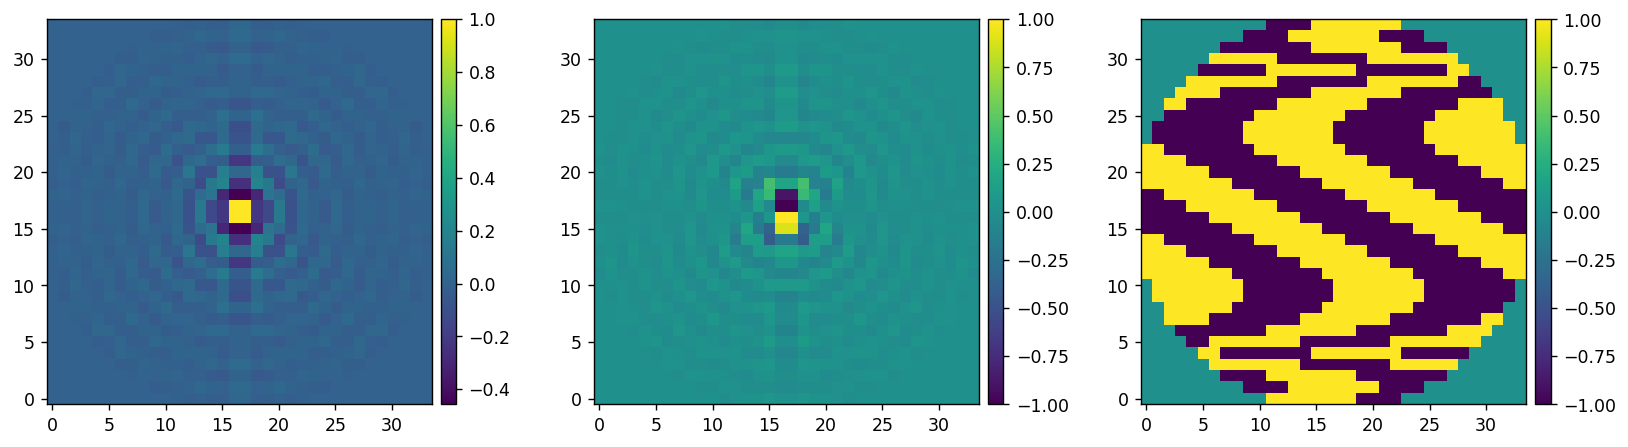

In [13]:
reload(utils)
reload(dm)
fourier_probes = ensure_np_array( dm.create_fourier_probes(
    M.dm_mask, 
    M.ncamsci, 
    M.camsci_pxscl_lamDc, 
    2,
    # 15, 
    13, 
    # iwa-1, 16, 
    rotation=90,
    use_weighting=True,
    nprobes=2,
))

calib_modes = ensure_np_array( dm.create_hadamard_modes(M.dm_mask) )

utils.imshow([fourier_probes[0], fourier_probes[1], calib_modes[8]], cmaps=3*['viridis'])

In [35]:
shmim_utils.write(2*[0.75] + (Nlo_modes-2)*[0.001], GAINS_STREAM)

In [33]:
DM_STREAM3.write(5e-9 * calib_modes[1000])

In [36]:

DM_STREAM3.write(dm_zeros)

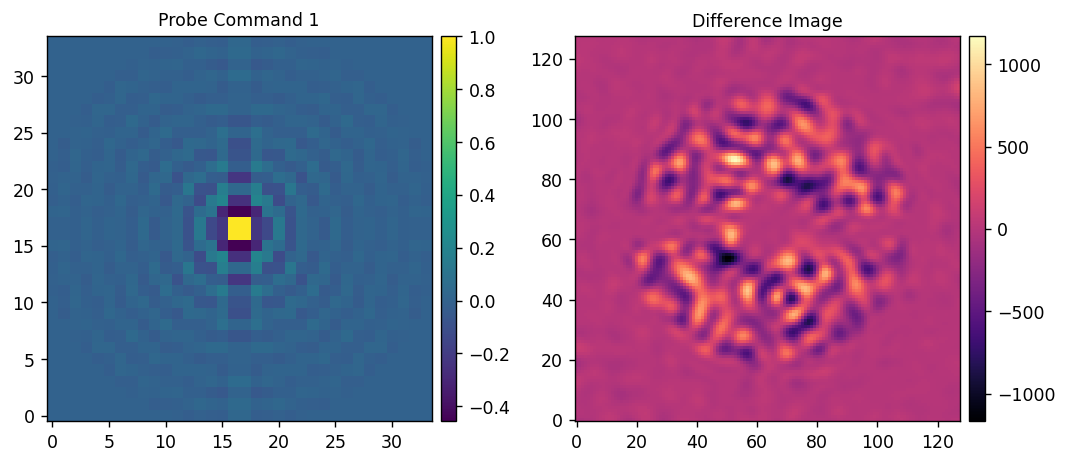

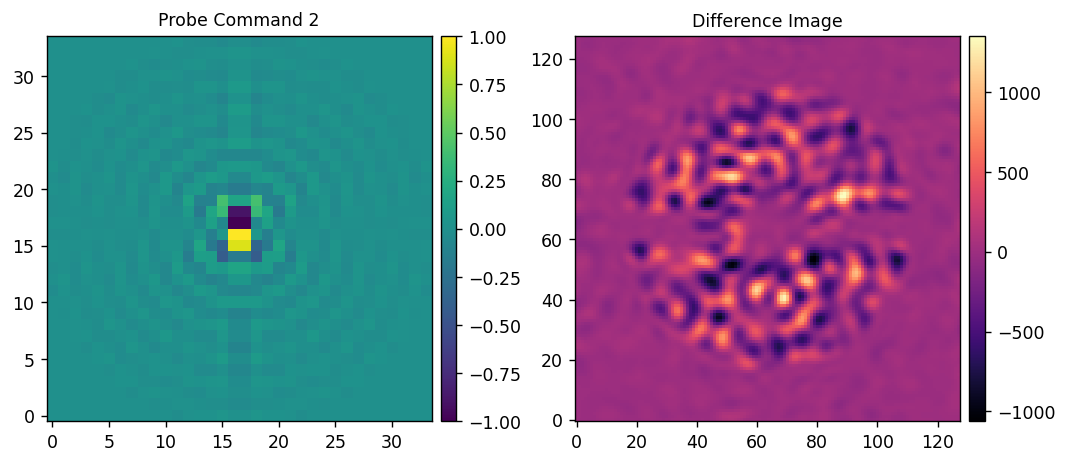

In [42]:
reload(iefc)
DM_STREAM3.write(dm_zeros)

diff_ims = iefc.take_measurement(
    CAMSCI_STREAM,
    50, 
    DM_STREAM3,
    fourier_probes,
    10e-9,
    plot=1,
)

Calibrating iEFC...
	Calibrated mode 1024/1024 in 2252.850s
Calibration complete.


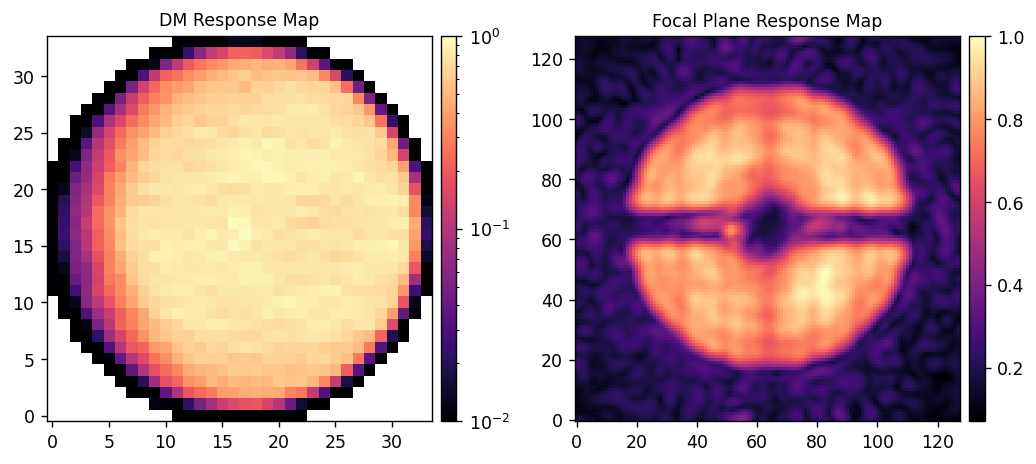

In [43]:
reload(iefc)
DM_STREAM3.write(dm_zeros)

calib_probe_amp = 10e-9
calib_mode_amp = 5e-9

response_matrix, response_cube = iefc.calibrate(
    CAMSCI_STREAM, 
    50,
    DM_STREAM3, 
    dh_mask, 
    calib_probe_amp, 
    fourier_probes, 
    calib_mode_amp, 
    calib_modes[:],
    delay=0.02,
    scale_factors=None, 
    plot_responses=True, 
)

In [44]:
reload(utils)
# iwa = 3
# owa = 15
# control_mask = utils.create_annular_focal_plane_mask(
#     M.ncamsci, 
#     M.camsci_pxscl_lamD, 
#     iwa, 
#     owa,  
#     edge=iwa,
#     rotation=90,
# )
# response_matrix = response_cube[:, :, control_mask.ravel()].reshape(calib_modes.shape[0], -1).T

# Compute a variety of control matrices so we can quickly switch between regularization values. 
cm20 = utils.beta_reg(response_matrix, -2, return_np=1)
cm25 = utils.beta_reg(response_matrix, -2.5, return_np=1)
cm30 = utils.beta_reg(response_matrix, -3, return_np=1)
cm35 = utils.beta_reg(response_matrix, -3.5, return_np=1)
cm40 = utils.beta_reg(response_matrix, -4, return_np=1)
cm45 = utils.beta_reg(response_matrix, -4.5, return_np=1)
cm50 = utils.beta_reg(response_matrix, -5, return_np=1)

In [45]:
DM_STREAM3.write(np.zeros(DM_STREAM3.shape))
iefc_data = {
    'images':[],
    'contrasts':[],
    'commands':[],
    'del_commands':[],
    'pixelscale':M.camsci_pxscl_lamDc,
    'control_mask':dh_mask, 
    'probes':fourier_probes,
}

In [47]:
shmim_utils.write(2*[0.75] + (Nlo_modes-2)*[0.01], GAINS_STREAM)

Running iteration 18 / 19
Measuring dark hole state ...


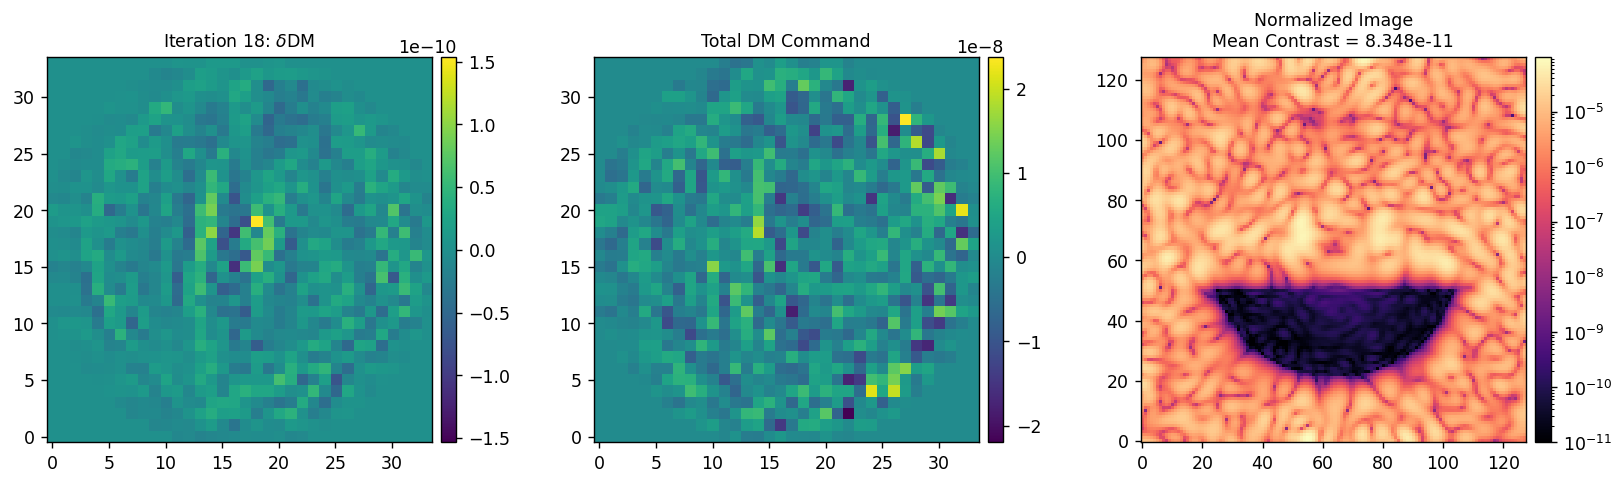

Running iteration 19 / 19
Measuring dark hole state ...


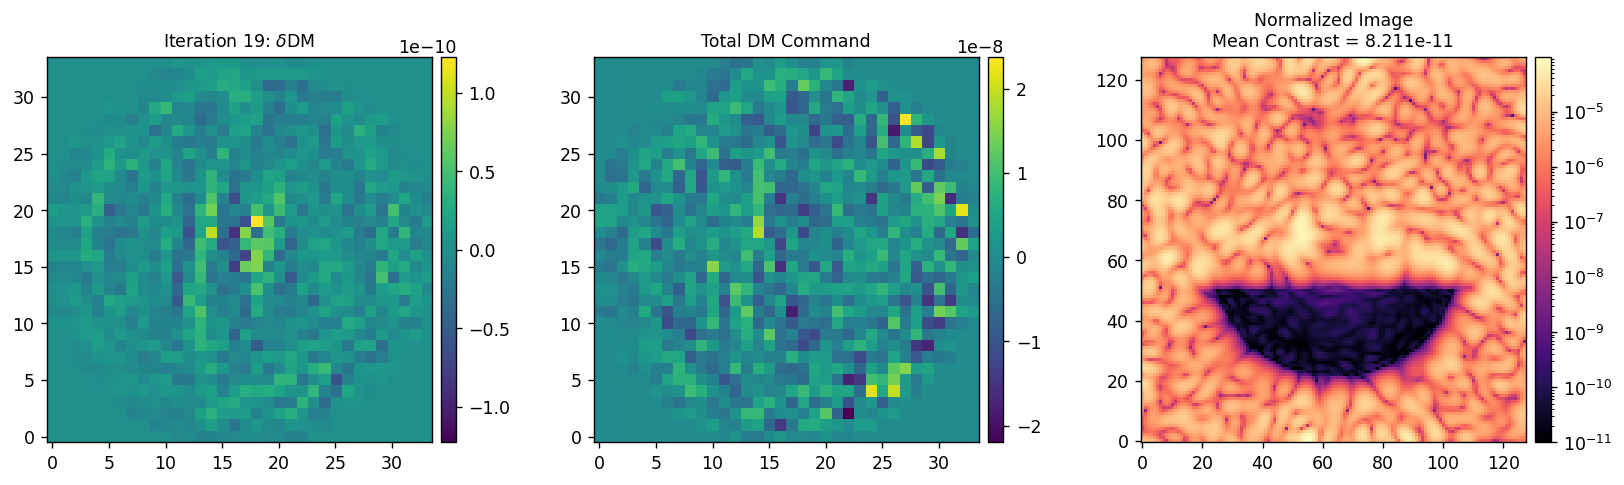

Completed 2 iterations in 51.576s.


In [57]:
reload(utils)
reload(iefc)

probe_amp = 2.5e-9
# probe_amp = 1e-9
probe_amp = 0.5e-9
probe_amp = 0.25e-9
# probe_amp = 0.1e-9

data = iefc.run(
    iefc_data,
    CAMSCI_STREAM,
    1000,
    DM_STREAM3,
    # cm20,
    cm25,
    # cm40,
    # cm45,
    # cm50,
    probe_amp, 
    fourier_probes, 
    calib_modes,
    dh_mask,
    delay=0.02,
    num_iterations=2,
    gain=1.0, 
    leakage=0.0,
    plot_current=True,
    plot_all=True,
    vmin=1e-11,
)

In [67]:
shmim_utils.write(2*[0.5] + (Nlo_modes-2)*[0.01/2], GAINS_STREAM)

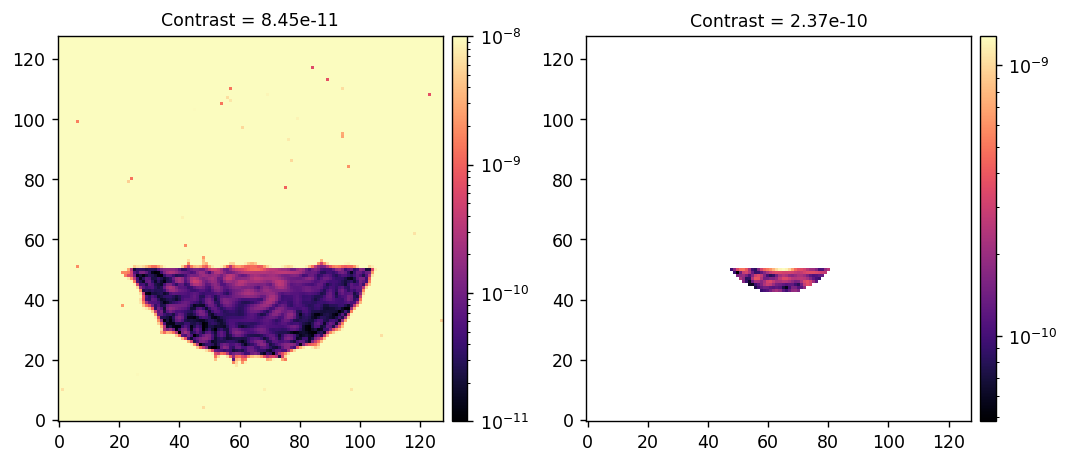

In [60]:
camsci_im = np.mean(CAMSCI_STREAM.grab_many(4000), axis=0)
contrast = np.mean(camsci_im[dh_mask])
contrast_3_5 = np.mean(camsci_im[coro_mask_3_5])

utils.imshow(
    [camsci_im, camsci_im*coro_mask_3_5],
    norms=[LogNorm(1e-11, 1e-8), LogNorm()],
    titles=[f'Contrast = {contrast:.2e}', f'Contrast = {contrast_3_5:.2e}'],
)

In [58]:
iefc_data.update({
    'response_matrix':response_matrix, 
    'response_cube':response_cube,
    'calib_modes':calib_modes,
    'calib_mode_amp':calib_mode_amp,
    'probe_modes':fourier_probes,
    'calib_probe_amp':calib_probe_amp,
})

utils.save_pickle('flight-sim-data-1K/flight_state_iefc_results_ff_offset_with_flat.pkl', iefc_data)


Saved data to:  flight-sim-data-1K/flight_state_iefc_results_ff_offset_with_flat.pkl


In [ ]:
DM_STREAM3.write(dm_zeros)

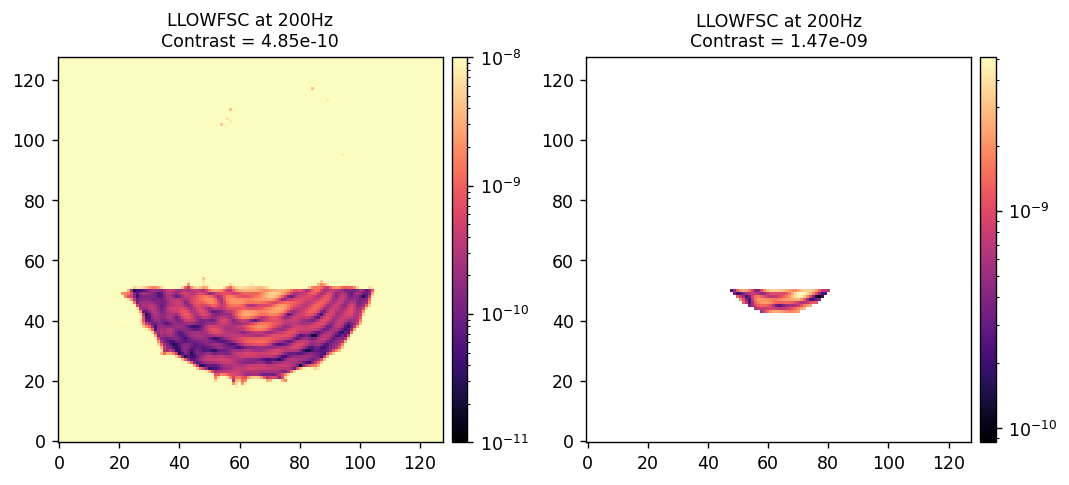

In [85]:
camsci_im = np.mean(CAMSCI_STREAM.grab_many(1000), axis=0)
contrast = np.mean(camsci_im[dh_mask])
contrast_3_5 = np.mean(camsci_im[coro_mask_3_5])

utils.imshow(
    [camsci_im, camsci_im*coro_mask_3_5],
    norms=[LogNorm(1e-11, 1e-8), LogNorm()],
    titles=[f'LLOWFSC at 200Hz\nContrast = {contrast:.2e}', f'LLOWFSC at 200Hz\nContrast = {contrast_3_5:.2e}']
)

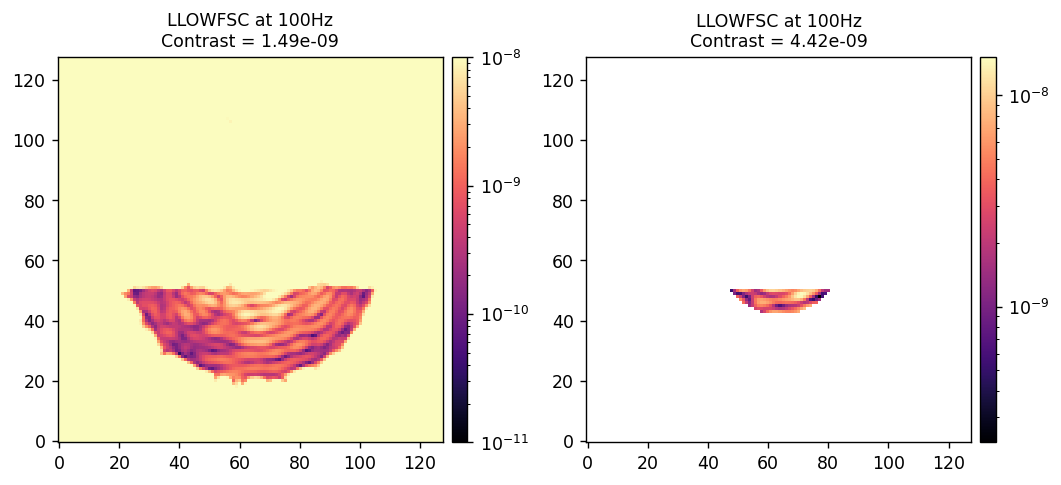

In [84]:
camsci_im = np.mean(CAMSCI_STREAM.grab_many(1000), axis=0)
contrast = np.mean(camsci_im[dh_mask])
contrast_3_5 = np.mean(camsci_im[coro_mask_3_5])

utils.imshow(
    [camsci_im, camsci_im*coro_mask_3_5],
    norms=[LogNorm(1e-11, 1e-8), LogNorm()],
    titles=[f'LLOWFSC at 100Hz\nContrast = {contrast:.2e}', f'LLOWFSC at 100Hz\nContrast = {contrast_3_5:.2e}']
)

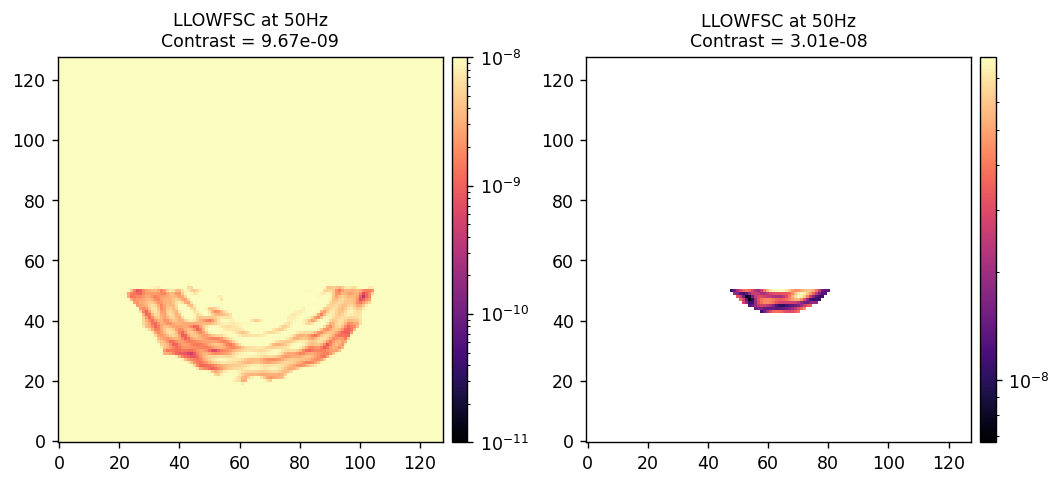

In [83]:
camsci_im = np.mean(CAMSCI_STREAM.grab_many(1000), axis=0)
contrast = np.mean(camsci_im[dh_mask])
contrast_3_5 = np.mean(camsci_im[coro_mask_3_5])

utils.imshow(
    [camsci_im, camsci_im*coro_mask_3_5],
    norms=[LogNorm(1e-11, 1e-8), LogNorm()],
    titles=[f'LLOWFSC at 50Hz\nContrast = {contrast:.2e}', f'LLOWFSC at 50Hz\nContrast = {contrast_3_5:.2e}']
)

# Load in and test previous iEFC data.

In [50]:
# iefc_data = utils.load_pickle('flight-sim-data/flight_state_iefc_results_1.pkl')
iefc_data = utils.load_pickle('flight-sim-data-1K/flight_state_iefc_results_ff_offset_with_flat.pkl')
iefc_commands = iefc_data['commands']
dh_mask = iefc_data['control_mask']

In [51]:
DM_STREAM3.write(iefc_commands[-1])